In [32]:
import fastai.vision.all as fv
import torch
from pathlib import Path
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
torch.cuda.set_device(1)

In [17]:
animals = Path("./datasets/AnimalsSmall")
source_images = (animals/"images")  
train = pd.read_csv("./datasets/AnimalsSmall/train.csv")

In [ ]:

print(f"Total images found: {len(train)}")
print(f"Classes: {train['Animal'].nunique()}")

Total images found: 13000
Classes: 30


In [12]:
len((animals/"images").ls())

13000

In [13]:
files = fv.get_image_files(animals/"images"); files

(#13000) [Path('datasets/AnimalsSmall/images/Img-9090.jpg'),Path('datasets/AnimalsSmall/images/Img-9810.jpg'),Path('datasets/AnimalsSmall/images/Img-5606.jpg'),Path('datasets/AnimalsSmall/images/Img-10096.jpg'),Path('datasets/AnimalsSmall/images/Img-9803.jpg'),Path('datasets/AnimalsSmall/images/Img-2224.jpg'),Path('datasets/AnimalsSmall/images/Img-620.jpg'),Path('datasets/AnimalsSmall/images/Img-2162.jpg'),Path('datasets/AnimalsSmall/images/Img-3952.jpg'),Path('datasets/AnimalsSmall/images/Img-11378.jpg'),Path('datasets/AnimalsSmall/images/Img-7565.jpg'),Path('datasets/AnimalsSmall/images/Img-2299.jpg'),Path('datasets/AnimalsSmall/images/Img-6918.jpg'),Path('datasets/AnimalsSmall/images/Img-11031.jpg'),Path('datasets/AnimalsSmall/images/Img-2385.jpg'),Path('datasets/AnimalsSmall/images/Img-7088.jpg'),Path('datasets/AnimalsSmall/images/Img-5573.jpg'),Path('datasets/AnimalsSmall/images/Img-12240.jpg'),Path('datasets/AnimalsSmall/images/Img-6342.jpg'),Path('datasets/AnimalsSmall/images/Im

In [18]:
destination_folder = (animals/"sorted_animals")

train_df, valid_df = train_test_split(train, test_size=0.2, random_state=42, stratify=train['Animal'])

def move_imgs(dataframe, set_type):
    print(f"\nOrganizing set of {set_type}...")
    for index, row in dataframe.iterrows():
        image_name = row['Image_id']
        label = row['Animal']
        
        folder_route = os.path.join(destination_folder, set_type, label)
        os.makedirs(folder_route, exist_ok=True)
        
        src = os.path.join(source_images, image_name)
        dst = os.path.join(folder_route, image_name)
        
        try:
            shutil.copy(src, dst) # Save the originals
        except FileNotFoundError:
            print(f"Not found: {image_name}")

move_imgs(train_df, 'train')
move_imgs(valid_df, 'valid')

print(f"\nDataset sorted in: '{destination_folder}'")


Organizing set of train...

Organizing set of valid...

Dataset sorted in: 'datasets/AnimalsSmall/sorted_animals'


In [29]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(flip_vert=True,
                             max_rotate=180,
                             max_lighting=0.25,
                             max_zoom=1.2,
                             max_warp=0.2)

    data = fv.DataBlock(blocks    = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label,
                        splitter  = fv.GrandparentSplitter(),
                        item_tfms = fv.Resize(img_size),
                        batch_tfms= tfms,
                     )
    return data.dataloaders(folder, bs=batch_size, num_workers=0)

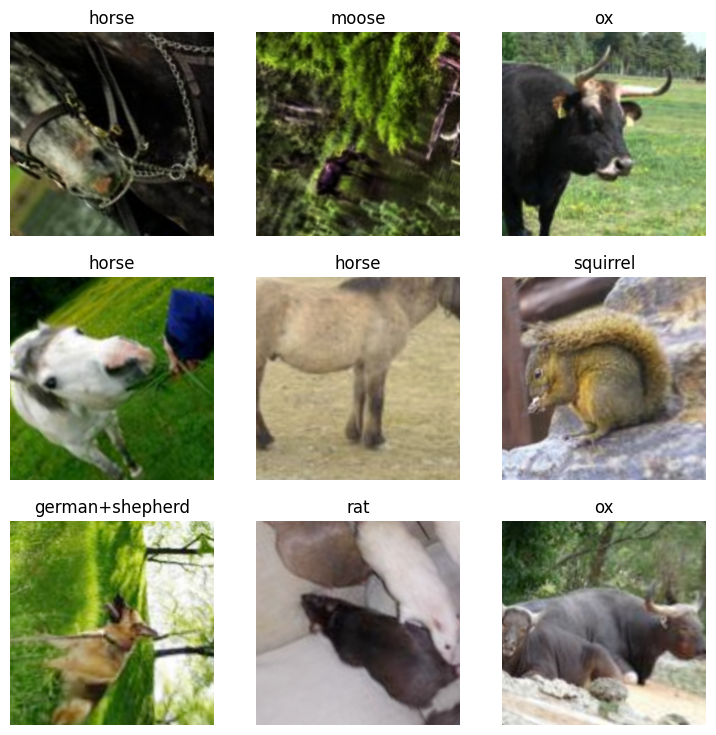

In [30]:
dls = load_data((animals/"sorted_animals"), img_size=224, batch_size=128)
dls.show_batch()

In [21]:
learn = fv.vision_learner(dls=dls, 
                          arch=fv.resnet18, 
                          metrics=fv.accuracy, 
                          opt_func=fv.ranger,)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/paquito/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 46.1MB/s]


In [22]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

SuggestedLRs(valley=0.005248074419796467)

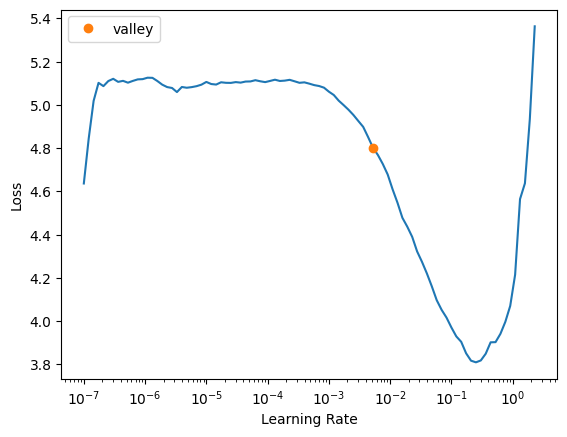

In [23]:
learn.lr_find()

In [24]:
learn.summary()

Sequential (Input shape: 128 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 64 x 112 x 11 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 56 x 56  
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                     

In [31]:
learn.fine_tune(epochs=5, base_lr=5e-3)

epoch,train_loss,valid_loss,accuracy,time


epoch,train_loss,valid_loss,accuracy,time
0,1.764359,0.661736,0.802692,00:16
1,1.409495,0.532980,0.836154,00:16
2,1.157757,0.492248,0.846923,00:16
3,0.973739,0.448686,0.865769,00:16
4,0.884045,0.451337,0.867308,00:16


In [33]:
interp = fv.ClassificationInterpretation.from_learner(learn)

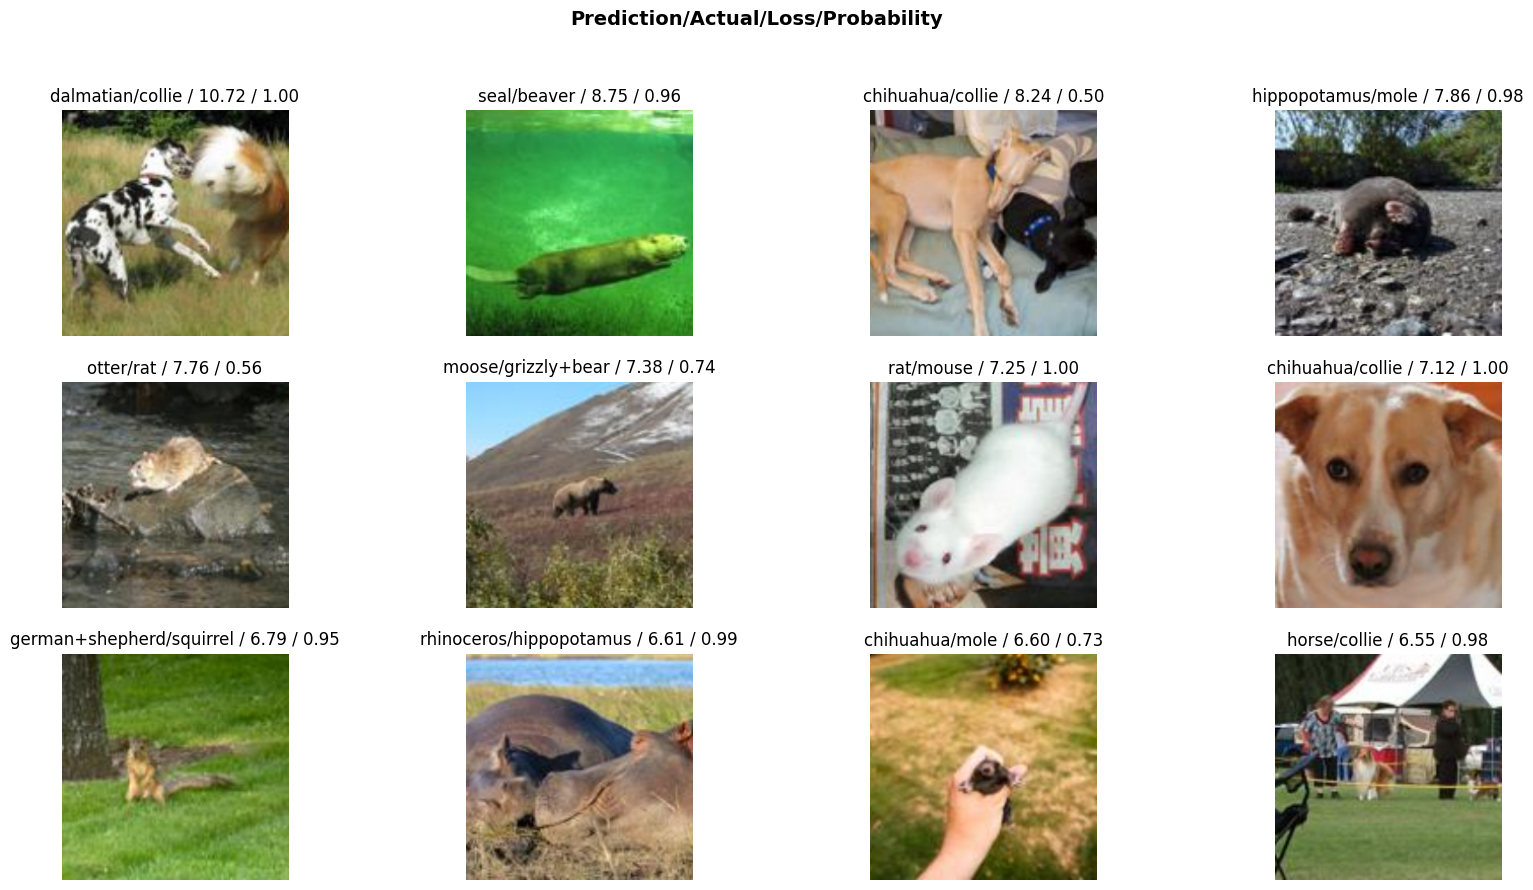

In [37]:
plt.rcParams["figure.figsize"] = (50, 20)
interp.plot_top_losses(12, figsize=(20,10))

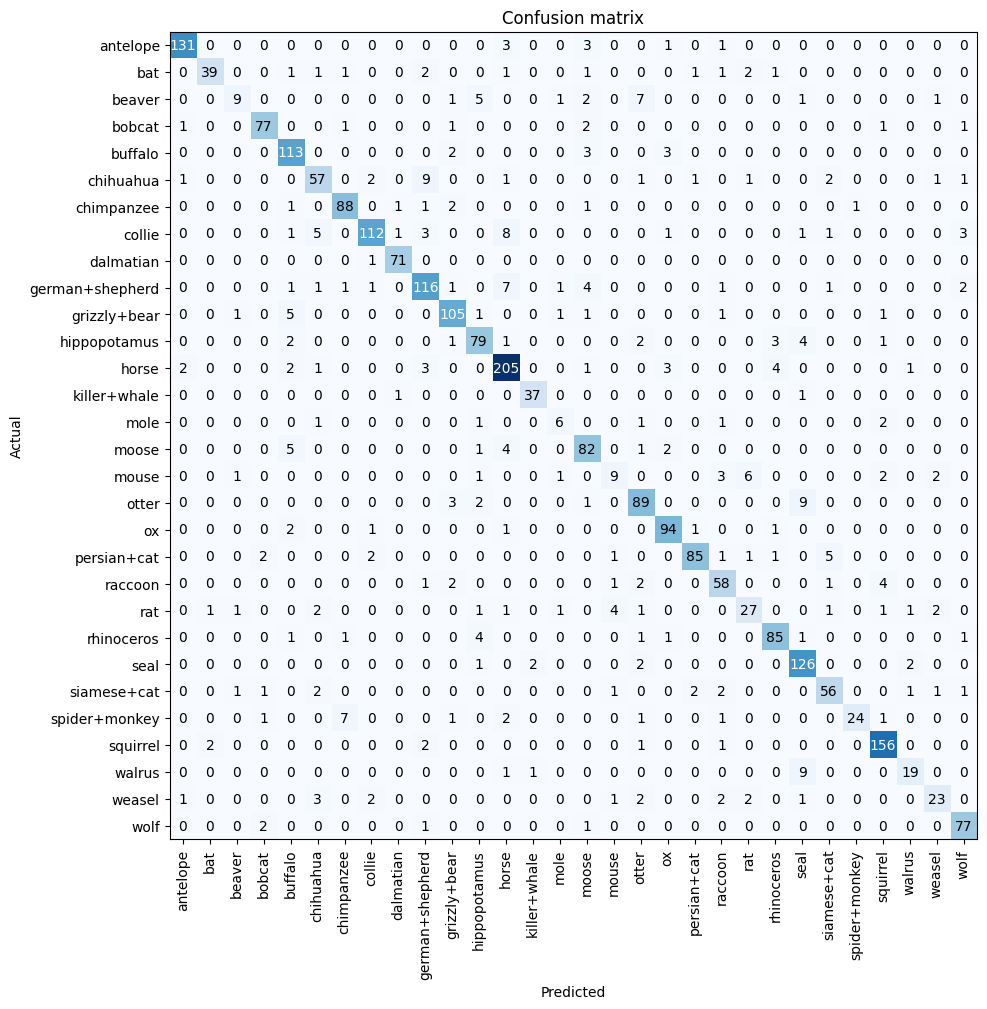

In [38]:
interp.plot_confusion_matrix(figsize=(10,10))

In [40]:
learn.export('./Tareas/animal_classifier.pkl')